# Upper Air Analysis 

This notebook shows the process of creating upper-air analyses using observational and model weather data.  Specifically, this notebook provides examples of:

1. Downloading recent and archived upper-air meteorological observations in netcdf format.
2. Reading observational data from netcdf datasets.
3. Quality controlling observational data.
4. Storing observational data in pandas dataframes.
5. Performing basic meteorological calculations.
6. Performing objective analysis and the impact of different radii of influence.
7. The impact of using model analyses as first guess fields for creating an upper air analysis.
8. Plotting upper-air analyses using metpy.

This notebook allows users to input any time, date, and location to examine analyses for any event users find interesting.  This also allows users to examine how different analysis techniques perform in different meteorological situations.

### 1. Load Required Libraries

In [61]:
#suppress warnings
import warnings
warnings.filterwarnings("ignore")

#import numpy library for working with numerical data
import numpy as np

#glob library for accessing the downloaded observational data
import glob

#datetime library for handling dates
from datetime import datetime, timedelta

#libraries for downloading observational data
import requests
import gzip
import shutil

#netcdf library for reading observational data
from netCDF4 import Dataset

#cartopy and matplotlib for plotting and visualization
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#pandas for creating data frame
import pandas as pd

#xarray for RAP model data
import xarray as xr
from xarray.backends import NetCDF4DataStore

#Siphon to parse and grab RAP model data for only the variables needed
from siphon.catalog import TDSCatalog

#various metpy functions and objects
from metpy.calc import reduce_point_density
import metpy.calc as mpcalc
import metpy.plots as mpplots
from metpy.plots import StationPlot, wx_code_to_numeric
from metpy.plots.wx_symbols import sky_cover, current_weather
from metpy.units import units
from metpy.interpolate import interpolate_to_grid, remove_nan_observations, interpolate_to_points
from metpy.io import metar
from metpy.plots.declarative import (BarbPlot, ContourPlot, FilledContourPlot, MapPanel,
                                     PanelContainer, PlotObs)

### 2. Define the pressure level, date, time, and location to analyze

Here the user can input a date, time, and location for the plot, and vertical pressure level for the analysis.  Users can either define the bounds of the domain to be plotted or provide a single latitude, longitude point from which a default area will be drawn.

Available pressure levels are:

 - 925 hPa
 - 850 hPa
 - 700 hPa
 - 500 hPa
 - 400 hPa
 - 300 hPa
 - 250 hPa
 - 200 hPa
 
Example dates and locations:
 
  1. Test
     - 2019 March 14 0000Z; location (lat,lon) = (37.5,-98.5)
  2. Test
     - 2019 March 14 0000Z; location (lat,lon) = (37.5,-98.5)
  

In [62]:
pres_lev = 500

#set time to plot
start_year  = 2019
start_month = 3
start_day   = 14
start_hour  = 0

#location to plot
location = True
location_lat = 37.5
location_lon = -98.5
#    OR
#analysis bounds
#location = False
lat_min = 30
lat_max = 35
lon_min = -86
lon_max = -81

In [63]:
#set-up bounds
if location:
    lat_min = location_lat-10
    lat_max = location_lat+10
    lon_min = location_lon-15
    lon_max = location_lon+15

### 3. Determining Data URL

If requested date is recent (within the past 3 days), the data is available via the recent MADIS dataset from NCEP:
 - https://madis-data.cprk.ncep.noaa.gov/madisPublic1/data/point/raob/netcdf/
 
Otherwise, data must be collected from the MADIS data archive from NCEP:
 - https://madis-data.cprk.ncep.noaa.gov/madisPublic1/data/archive/
 
The data URL is printed to allow users to archive data directly if they choose.

In [64]:
#calculate the number of days since requested date
dt = datetime(start_year,start_month,start_day,start_hour)
del_t = datetime.now()-dt
del_t_days = del_t.days + (del_t.seconds/60/60/24)

#if the requested date if over 3 days ago, use the MADIS archive
if del_t_days>3:
    base_url = 'https://madis-data.cprk.ncep.noaa.gov/madisPublic1/data/archive/'
    url = f'{base_url}{dt:%Y}/{dt:%m}/{dt:%d}/point/raob/netcdf/{dt:%Y%m%d_%H%M}.gz'

#otherwise use MADIS recent data
else:
    base_url = 'https://madis-data.cprk.ncep.noaa.gov/madisPublic1/data/point/raob/netcdf/'
    url = f'{base_url}{dt:%Y%m%d_%H%M}.gz'

print(url)


https://madis-data.cprk.ncep.noaa.gov/madisPublic1/data/archive/2019/03/14/point/raob/netcdf/20190314_0000.gz


### 4. Downloading RAOBs from Online
RAOB data at the determined URL is downloaded to the local directory as a NETCDF4 formatted dataset.  This data is stored as "temp.nc" to limit storage requirements.

In [65]:
#download dataset
r = requests.get(url,allow_redirects=True)
open('temp.nc.gz','wb').write(r.content)
#uncompress the observational data using g-zip
with gzip.open('temp.nc.gz','rb') as f_in:
    with open('temp.nc','wb') as f_out:
        shutil.copyfileobj(f_in,f_out)


### 5a. Open RAOB dataset and begin reading data
The data is stored such that times are recorded in "unix time" or the number of seconds since 0000Z on 1 January 1970.  Unix time is defined and time is converted using the "timedelta" function from the datetime library.

In [66]:
#open the netcdf dataset
data=Dataset('temp.nc','r')

#convert times
UNIX_TIME = datetime(1970,1,1,0)
time = [UNIX_TIME + timedelta(seconds=float(t)) for t in data['synTime']]

#read in latitude and longitude
#if no data is reported, fill those values with Not-A-Numbers
lat = data['staLat'][:]
lat = lat.filled(np.nan)
lon = data['staLon'][:]
lon = lon.filled(np.nan)



### 5b. Read in meteorological data and perform quality control
Check that the data makes sense.  If not, get rid of it.

In [67]:
#read in the name of the observation station
name = data['staName'][:]
name = [i.tostring().decode()[:4] for i in name]

#read in pressure and geopotential height data
pres = data['prMan'][:]
pres = pres.filled(np.nan)
hght = data['htMan'][:]
hght = hght.filled(np.nan)

#read in temperature and dewpoint data (in Kelvin)
#if temperature is below 100 K, assume it's bad
temp = data['tpMan'][:]
temp = temp.filled(np.nan)
temp[temp<100]=np.nan
temp = (temp-273.15)
dwptdp = data['tdMan'][:]
dwptdp = dwptdp.filled(np.nan)
dwptdp[dwptdp<100]=np.nan
dwptdp = (dwptdp-273.15)

#read in wind speed and direction.  If over 250 m/s, assume it's bad
wdir = data['wdMan'][:]
wdir = wdir.filled(np.nan)
wdir[wdir<0] = np.nan
wspd = data['wsMan'][:]
wspd = wspd.filled(np.nan)
wspd[wspd>250] = np.nan

#calculate u,v components from wind speed and direction
u,v = mpcalc.wind_components((wspd*units('m/s')).to('knots'),wdir*units.degree)


### 6. Convert RAOB data to pandas dataframe
Because of the format of RAOB data - several stations each having several observations - it's easier to create an xarray dataset and then convert to pandas.

In [118]:
#create xarray dataset
ds = xr.Dataset(
        coords=dict(
            id=(['id'],name)
            ),
        data_vars=dict(
            lon=(['id'],lon),
            lat=(['id'],lat),
            pressure=(['id','pres'],pres),
            height=(['id','pres'],hght),
            temperature=(['id','pres'],temp),
            dwptdp=(['id','pres'],dwptdp),
            u=(['id','pres'],u),
            v=(['id','pres'],v)
            )
    )

#convert to pandas dataframe and remove obs with nans for lat/lon
df=ds.to_dataframe()
df=df[df['lat'].notna()]
df=df[df['lon'].notna()]

### 7. Subset the data for the requested vertical level
This is put in a new dataframe just incase we want to plot a different level later, we haven't thrown out the data.

In [119]:
df_sub = df[df['pressure']==pres_lev]

### 8. Analyze Geopotential Height

While meteorology students typically learn how to contour upper-air charts using observations, this is done subjectively by estimating where the contours should be plotted.  Computers prefer to do things mathematically (objective analysis).

The code below uses the Cressman (1959) weighting function to perform objective analysis.

The analysis options are:
 - hres = the horizontal resolution of the analysis in meters; 100,000 is good for zoomed in areas, larger values can speed up 
 - search_radius = use observations if they are closer to the analysis point than this value in meters (larger value uses more observations); 700,000m is a good value, but make sure to see the impact of different radii

In [120]:
hres = 100000
search_radius = 700000 

proj = ccrs.LambertConformal(central_latitude=(lat_min+lat_max) / 2,
                                     central_longitude=(lon_min+lon_max) / 2)

hghtdf = df_sub.dropna(subset=['height'],inplace=False)
    
point_locs = proj.transform_points(ccrs.PlateCarree(),df_sub['lon'].values,df_sub['lat'].values)
point_locs_hght = proj.transform_points(ccrs.PlateCarree(),hghtdf['lon'].values,hghtdf['lat'].values)

xp,yp,null = point_locs_hght.T

hghtgridx, hghtgridy, height = interpolate_to_grid(xp,yp,hghtdf['height'],
                                                    interp_type='cressman',
                                                    minimum_neighbors=1,hres=hres,search_radius=search_radius)

### 9. Plot Analysis

Plot the upper-air geopotential heigh analysis on a map along with station plots.


### 9a. Define Contour Levels

In [121]:
if pres_lev == 925:
    pre_ctours = np.arange(500,900,30)
elif pres_lev == 850:
    pre_ctours = np.arange(1100,1900,30)
elif pres_lev == 700:
    pre_ctours = np.arange(2400,3600,30)
elif pres_lev == 500:
    pre_ctours = np.arange(4000,6500,60)
elif pres_lev == 400:
    pre_ctours = np.arange(6800,8000,60)
elif pres_lev == 300:
    pre_ctours = np.arange(8200,10400,60)
elif pres_lev == 250:
    pre_ctours = np.arange(10000,11500,60)
elif pres_lev == 200:
    pre_ctours = np.arange(10900,13000,60)

### 9b. Create Figure

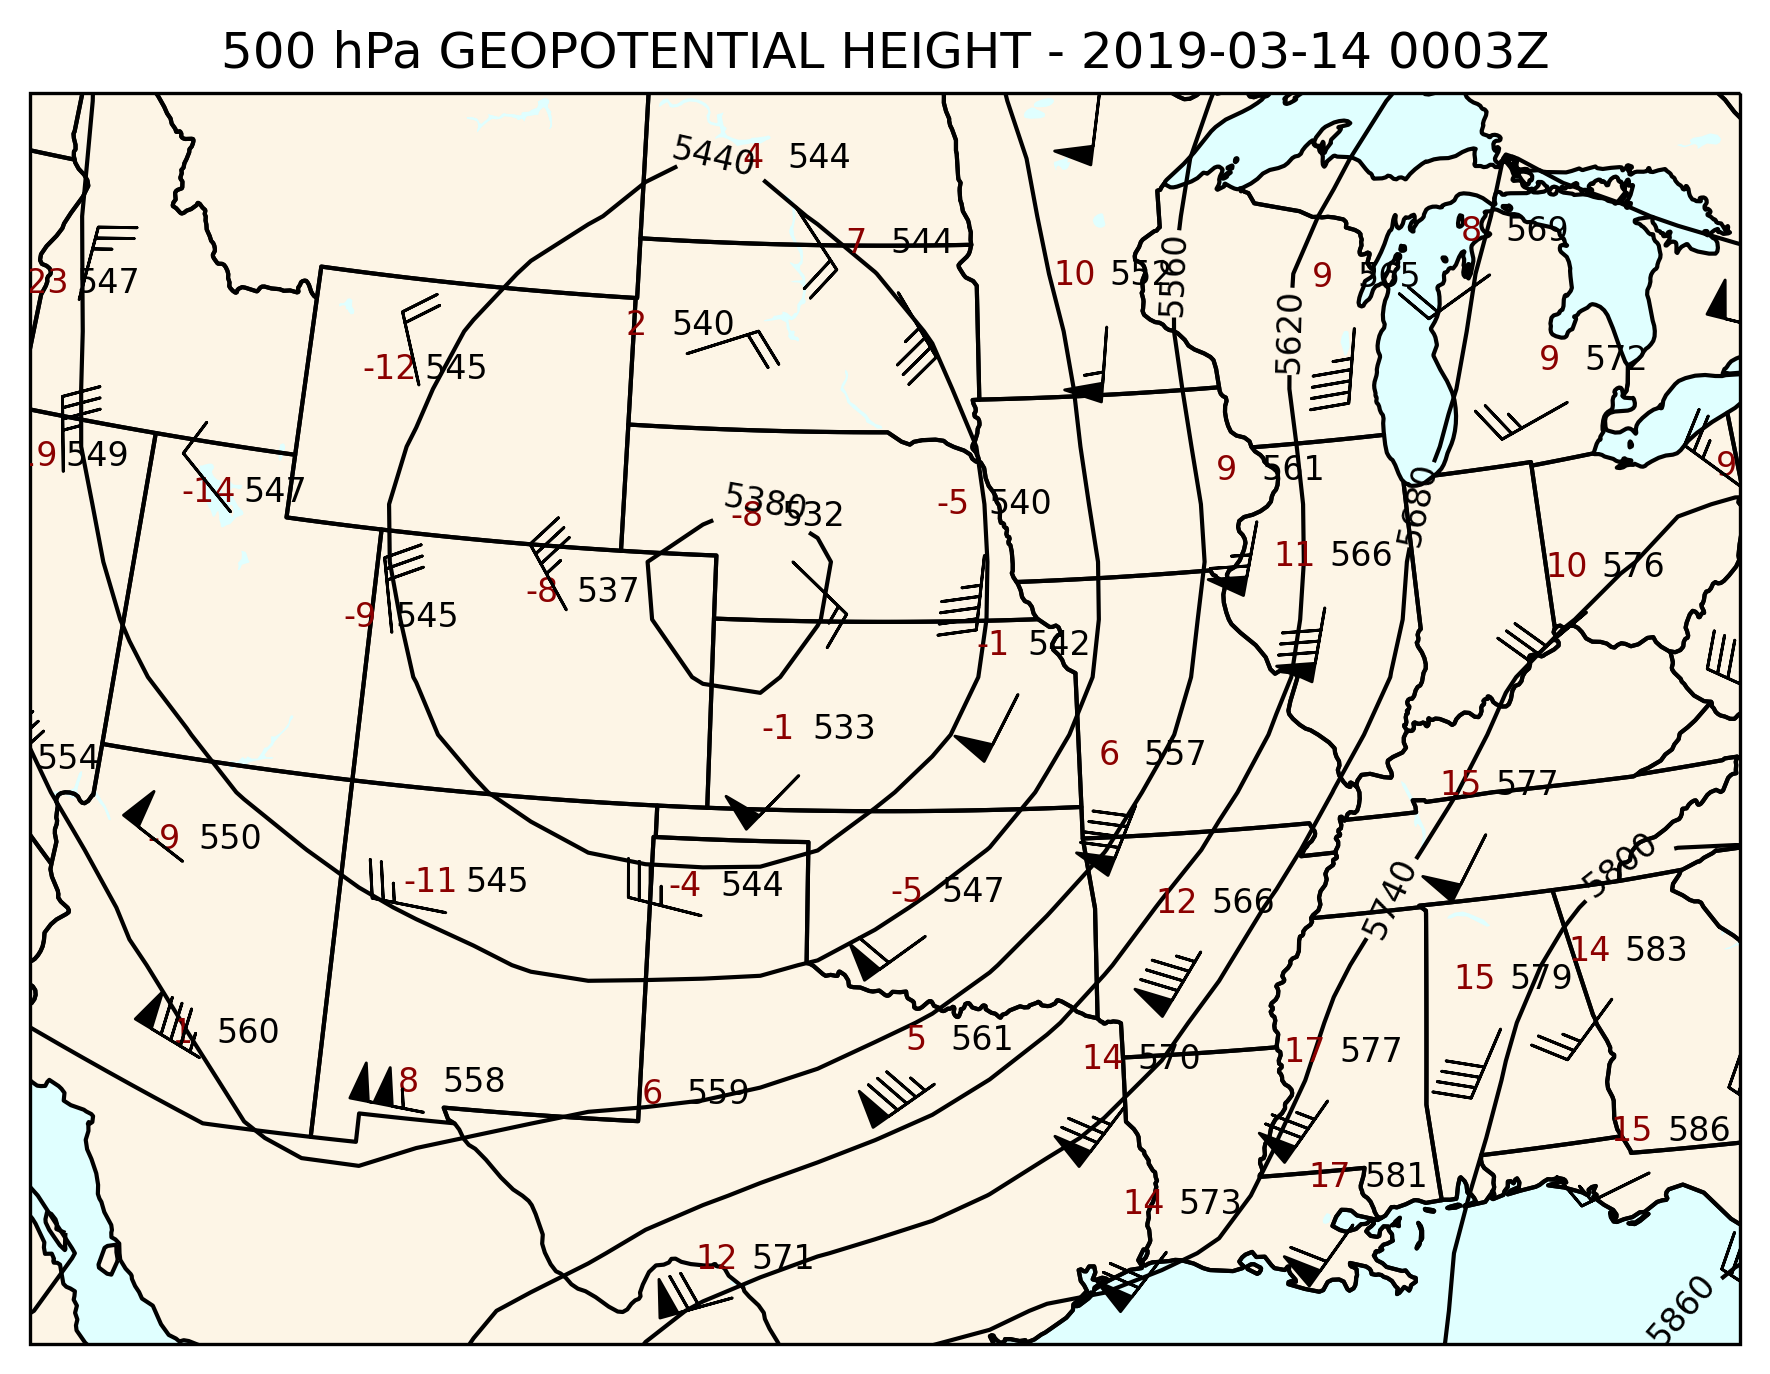

In [122]:
fig=plt.figure(figsize=(6,6),dpi=300)
proj = ccrs.LambertConformal(central_latitude=(lat_min+lat_max) / 2,
                                     central_longitude=(lon_min+lon_max) / 2)
ax = fig.add_subplot(1,1,1,projection=proj)
ax.add_feature(cfeature.NaturalEarthFeature('physical','land','50m',facecolor='oldlace'))
ax.add_feature(cfeature.NaturalEarthFeature('physical','ocean','50m',facecolor='lightcyan'))
ax.add_feature(cfeature.NaturalEarthFeature('physical','lakes','50m',facecolor='lightcyan'))
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)
ax.set_extent((lon_min,lon_max,lat_min,lat_max))

stationplot = StationPlot(ax,df_sub['lon'].values,df_sub['lat'].values,clip_on=True, transform=ccrs.PlateCarree(),fontsize=8)
stationplot.plot_parameter('NW',df_sub['temperature']*(9.0/5.0)+32.0,color='darkred',fontsize=8)
stationplot.plot_parameter('NE',df_sub['height'],color='black',formatter=lambda v: format(v, '.0f')[:3],fontsize=8)
stationplot.plot_parameter('SW',df_sub['dwptdp']*(9.0/5.0)+32.0,color='darkgreen',fontsize=8)
stationplot.plot_barb(np.array(df_sub['u'].values,dtype=float),np.array(df_sub['v'].values,dtype=float),linewidth=0.7,length=6,zorder=10)

cs = plt.contour(hghtgridx,hghtgridy,height,colors='k',levels=pre_ctours,linewidths=1)

plt.clabel(cs, inline=1, fontsize=8, fmt='%i')
fig.tight_layout()
plt.title('%i hPa GEOPOTENTIAL HEIGHT - %sZ'%(int(pres_lev),dt.strftime('%Y-%m-%d %H%m')))
plt.show()

## Advanced Analysis
The cells below are more for demonstration of more advanced analyses.  They show how using model output as a first guess can be used to create a better analysis.

### 10. Determine RAP online location
RAP model analyses and forecasts are available at the NCEI Thredds catalog.  More recent data is available at:
  - https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl/
While older data is available at :
  - https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl-old/
This script checks both datasets, if that time is unavailable, an error is printed.

In [123]:
#get rap data
try:
    base_url = 'https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl/'
    cat = TDSCatalog(f'{base_url}{dt:%Y%m}/{dt:%Y%m%d}/catalog.xml')
    ds = cat.datasets.filter_time_range(dt,dt+timedelta(hours=0))[-1]
    ncss = ds.subset()
except requests.exceptions.HTTPError as err:
    try:
        base_url = 'https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl-old/'
        cat = TDSCatalog(f'{base_url}{dt:%Y%m}/{dt:%Y%m%d}/catalog.xml')
        ds = cat.datasets.filter_time_range(dt,dt+timedelta(hours=0))[-1]
        ncss = ds.subset()
    except requests.exceptions.HTTPError as err:
        print("   Date not in catalog.  Exiting...\n")
        sys.exit()


### 11. Download RAP data for the domain
NCSS allows us to only download a subset of the data as opposed to the whole model run.  This script selects data nearby the domain, and selects relevant upper air variables.

In [124]:
query = ncss.query()
query.lonlat_box(north=lat_max+3,south=lat_min-3,east=lon_max+3,west=lon_min-3)
query.all_times()
query.add_lonlat()
query.accept('netcdf')
query.variables('Geopotential_height_isobaric',
                    'Relative_humidity_isobaric',
                    'u-component_of_wind_isobaric',
                    'v-component_of_wind_isobaric',
                    'Temperature_isobaric')
rap_data = ncss.get_data(query)


### 12. Open RAP Data
Data is opened, subset to only the pressure level desired, and downsampled to 5-times to increase computational speed.

In [125]:
rap_ds = xr.open_dataset(NetCDF4DataStore(rap_data)).metpy.parse_cf()

#select data at the vertical pressure level desired
#subset every 5th model point in both x and y directions.
rap_temp = np.array(rap_ds['Temperature_isobaric'][0].metpy.sel(vertical=pres_lev*units.hPa))[::5,::5]
rap_rh = np.array(rap_ds['Relative_humidity_isobaric'][0].metpy.sel(vertical=pres_lev*units.hPa))[::5,::5]
rap_u = np.array(rap_ds['u-component_of_wind_isobaric'][0].metpy.sel(vertical=pres_lev*units.hPa))[::5,::5]
rap_v = np.array(rap_ds['v-component_of_wind_isobaric'][0].metpy.sel(vertical=pres_lev*units.hPa))[::5,::5]
rap_hgt = np.array(rap_ds['Geopotential_height_isobaric'][0].metpy.sel(vertical=pres_lev*units.hPa))[::5,::5]
rap_lon = np.array(rap_ds.lon)[::5,::5]
rap_lat = np.array(rap_ds.lat)[::5,::5]

#calculate wind speed from u,v components
rap_ds['wind_speed'] = mpcalc.wind_speed(rap_ds['u-component_of_wind_isobaric'],
                                     rap_ds['v-component_of_wind_isobaric'])

rap_wspd = np.array(rap_ds['wind_speed'][0].metpy.sel(vertical=pres_lev*units.hPa))[::5,::5]

### 11. Perform analysis
The analysis now uses model data as the "first guess".  This is done similar to the successive corrections method (see the surface analysis script).

### 11a. First perform analysis on RAP data
Because rap data is very dense (13 km), we can use a much smaller search radius for determining the RAP analysis.  50,000 meters is a good starting point.

In [126]:
search_radius = 100000

proj = ccrs.LambertConformal(central_latitude=(lat_min+lat_max) / 2,
                                     central_longitude=(lon_min+lon_max) / 2)
hghtdf = df_sub.dropna(subset=['height'],inplace=False)
bounds_locs = proj.transform_points(ccrs.PlateCarree(),np.array([lon_min-10,lon_max+10]),np.array([lat_max+10,lat_min-10]))
bounds = dict({'north':bounds_locs[0,1],'east':bounds_locs[1,0],'south':bounds_locs[1,1],'west':bounds_locs[0,0]})

rap_locs = proj.transform_points(ccrs.PlateCarree(),rap_lon.flatten(),rap_lat.flatten())
rxp,ryp,null = rap_locs.T
rap_locs = np.transpose([rxp,ryp])

hghtgridx_n, hghtgridy_n, rap_height = interpolate_to_grid(rxp,ryp,rap_hgt.flatten(),
                                            interp_type='cressman',
                                            minimum_neighbors=1,hres=hres,boundary_coords=bounds,
                                            search_radius=search_radius)


### 11b. Now, perform analysis using RAOBs
First, RAP values need to be calculated at the RAOB locations.  This will follow a successive corrections method, where the difference between the RAP analysis and RAOB values is interpolated to the analysis locations to create a "corrected" analysis.

In [127]:
search_radius = 700000

point_locs = proj.transform_points(ccrs.PlateCarree(),df_sub['lon'].values,df_sub['lat'].values)
point_locs_hght = proj.transform_points(ccrs.PlateCarree(),hghtdf['lon'].values,hghtdf['lat'].values)
xp,yp,null = point_locs_hght.T
stns = np.transpose([xp,yp])

hght_bg = interpolate_to_points(rap_locs,rap_hgt.flatten(),stns,interp_type='cressman',search_radius=search_radius)
dhgt = hghtdf['height'].values-hght_bg

hghtgridx_n, hghtgridy_n, height_n = interpolate_to_grid(xp,yp,dhgt,
                                            interp_type='cressman',
                                            minimum_neighbors=1,hres=hres,boundary_coords=bounds,
                                            search_radius=search_radius)

height_n = np.nansum([height_n,rap_height],axis=0)


### 12. Plot upper air from RAOB analysis before and new RAOB analysis using RAP

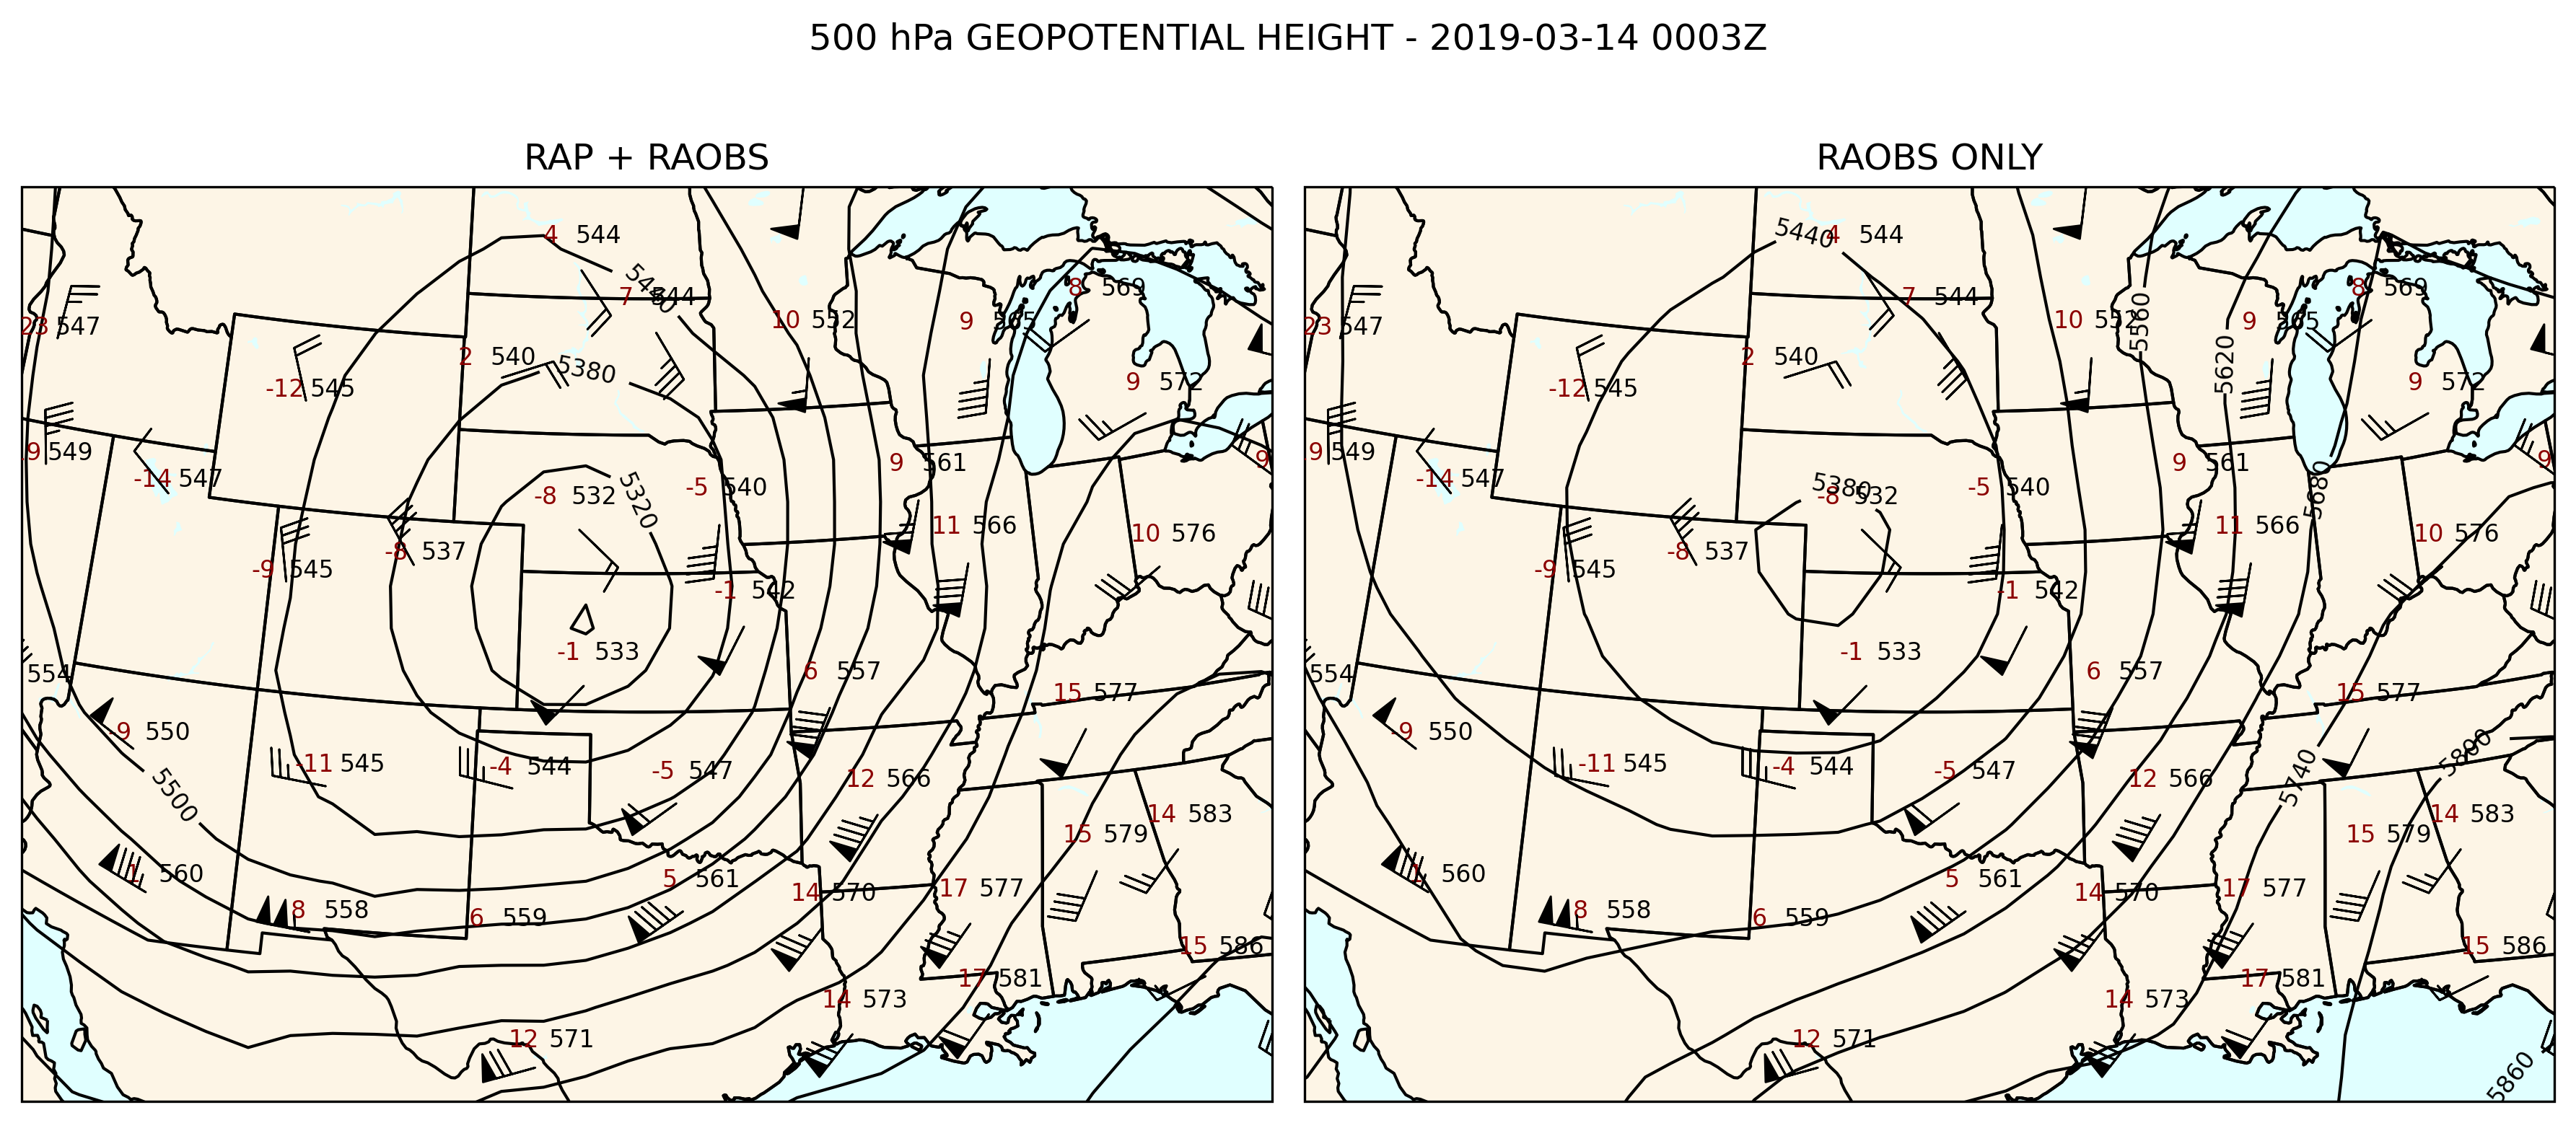

In [132]:
#plot RAOB + RAP analysis
fig=plt.figure(figsize=(12,6),dpi=300)
proj = ccrs.LambertConformal(central_latitude=(lat_min+lat_max) / 2,
                                     central_longitude=(lon_min+lon_max) / 2)
ax = fig.add_subplot(1,2,1,projection=proj)
ax.add_feature(cfeature.NaturalEarthFeature('physical','land','50m',facecolor='oldlace'))
ax.add_feature(cfeature.NaturalEarthFeature('physical','ocean','50m',facecolor='lightcyan'))
ax.add_feature(cfeature.NaturalEarthFeature('physical','lakes','50m',facecolor='lightcyan'))
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)
ax.set_extent((lon_min,lon_max,lat_min,lat_max))

stationplot = StationPlot(ax,df_sub['lon'].values,df_sub['lat'].values,clip_on=True, transform=ccrs.PlateCarree(),fontsize=8)
stationplot.plot_parameter('NW',df_sub['temperature']*(9.0/5.0)+32.0,color='darkred',fontsize=8)
stationplot.plot_parameter('NE',df_sub['height'],color='black',formatter=lambda v: format(v, '.0f')[:3],fontsize=8)
stationplot.plot_parameter('SW',df_sub['dwptdp']*(9.0/5.0)+32.0,color='darkgreen',fontsize=8)
stationplot.plot_barb(np.array(df_sub['u'].values,dtype=float),np.array(df_sub['v'].values,dtype=float),linewidth=0.7,length=6,zorder=10)

cs = plt.contour(hghtgridx_n,hghtgridy_n,height_n,colors='k',levels=pre_ctours,linewidths=1)

plt.clabel(cs, inline=1, fontsize=8, fmt='%i')
plt.title('RAP + RAOBS')

#plot original RAOB-only analysis
ax = fig.add_subplot(1,2,2,projection=proj)
ax.add_feature(cfeature.NaturalEarthFeature('physical','land','50m',facecolor='oldlace'))
ax.add_feature(cfeature.NaturalEarthFeature('physical','ocean','50m',facecolor='lightcyan'))
ax.add_feature(cfeature.NaturalEarthFeature('physical','lakes','50m',facecolor='lightcyan'))
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)
ax.set_extent((lon_min,lon_max,lat_min,lat_max))

stationplot = StationPlot(ax,df_sub['lon'].values,df_sub['lat'].values,clip_on=True, transform=ccrs.PlateCarree(),fontsize=8)
stationplot.plot_parameter('NW',df_sub['temperature']*(9.0/5.0)+32.0,color='darkred',fontsize=8)
stationplot.plot_parameter('NE',df_sub['height'],color='black',formatter=lambda v: format(v, '.0f')[:3],fontsize=8)
stationplot.plot_parameter('SW',df_sub['dwptdp']*(9.0/5.0)+32.0,color='darkgreen',fontsize=8)
stationplot.plot_barb(np.array(df_sub['u'].values,dtype=float),np.array(df_sub['v'].values,dtype=float),linewidth=0.7,length=6,zorder=10)

cs = plt.contour(hghtgridx,hghtgridy,height,colors='k',levels=pre_ctours,linewidths=1)

plt.clabel(cs, inline=1, fontsize=8, fmt='%i')
plt.title('RAOBS ONLY')
fig.tight_layout()
plt.suptitle('%i hPa GEOPOTENTIAL HEIGHT - %sZ'%(int(pres_lev),dt.strftime('%Y-%m-%d %H%m')))
plt.show()